# Duck Egg Quality Classification Based on its Shell Visual Property through Image Processing and Deep Learning


Group CGM: <br>

Caguioa, JV Bryan <br>
Guinto, Ryhle Nodnyhlson <br>
Mesias, Lee Reuben

# References

https://thedatafrog.com/en/articles/image-recognition-transfer-learning/ <br>
https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538 <br>
https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python <br>
https://keras.io/examples/vision/grad_cam/

## Imports

In [1]:
import os                                              # define and move to dataset and model directory
import shutil                                          # duplicate images and delete directories
import sys                                             # exit out code     
import cv2                                             

import tensorflow.keras as keras
import numpy as np
import tensorflow as tf                                 #for callbacks
import seaborn as sn
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt                         #histograph/confusion matrix

from sklearn.model_selection import StratifiedKFold     #k-fold cross validation
from sklearn.model_selection import train_test_split    #split the dataset to train-test

from tensorflow.keras.preprocessing.image import ImageDataGenerator      # data augmentation
from tensorflow.keras.preprocessing import image as im                   #load image
from tensorflow.keras.applications.resnet50 import preprocess_input      #preprocess image                                                               

#measure performance metrics
#---------------------------------------------------------------------------------------------------------------------
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc       
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import label_binarize

from scipy import interp                            #interpolation needed for plotting all classes into one roc plot
from itertools import cycle                         #for the color of lines on that multiclass plot
#---------------------------------------------------------------------------------------------------------------------

#Grad-CAM
from IPython.display import Image, display
import matplotlib.cm as cm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# the directory where the data is stored
directory = "C:/Users/user/Desktop/Dataset"
#directory where set of models per training are stored
gen_dir = "C:/Users/user/Desktop/Model"

if not os.path.exists(directory):
    os.makedirs(directory)
if not os.path.exists(gen_dir):
    os.makedirs(gen_dir)

## Put Dataset in a Dataframe

The directory of the images are put in a dataframe in order to prepare for splitting the dataset into train and test set.

In [3]:
totaldsdirect = directory + "/CombinedFourAngleEggs"

image = []

if not os.path.exists(totaldsdirect):
    print("Directory does not exist. Please run the code on data cleaning notebook.")
    sys.exit()

#label the images
for x in os.listdir(totaldsdirect):
    totaldsdirect2 = totaldsdirect + "/" + x
    for y in os.listdir(totaldsdirect2):
        if x == "Balut-penoy5":
            lbl = "0"
        elif x == "Salted egg5":
            lbl = "1"
        else:
            lbl = "2"
                 
        #append to image array
        image.append([totaldsdirect2 + "/" + y,lbl])

In [4]:
df = pd.DataFrame(image,columns=['filename','label'])
df

,filename,label
0,C:/Users/user/Desktop/Dataset/CombinedFourAngl...,0
1,C:/Users/user/Desktop/Dataset/CombinedFourAngl...,0
2,C:/Users/user/Desktop/Dataset/CombinedFourAngl...,0
3,C:/Users/user/Desktop/Dataset/CombinedFourAngl...,0
4,C:/Users/user/Desktop/Dataset/CombinedFourAngl...,0
...,...,...
595,C:/Users/user/Desktop/Dataset/CombinedFourAngl...,2
596,C:/Users/user/Desktop/Dataset/CombinedFourAngl...,2
597,C:/Users/user/Desktop/Dataset/CombinedFourAngl...,2
598,C:/Users/user/Desktop/Dataset/CombinedFourAngl...,2


Classes: <br>
0 - Balut/Penoy <br> 
1 - Salted <br>
2 - Table

## Split Data to train and test set

We will need to split the dataset to train and test set (90:10). The train set will be used for Hyperparameter tuning with Stratified K-fold Cross Validation to find the best hyperparameters and use that as the hyperparameters to train the final model using the train set. Test set will be used for model prediction and model evaluation. Stratify is used in order to split the data in equal numbers under each class specified.

In [5]:
# Split the data to train and test
X = df[['filename']]
y = df[['label']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=420)

Save the images in the split sets to train and test set folders.

In [6]:
#folder to store the train and test set folders
fortraintest = directory + "/ToBeUsed"
if not os.path.exists(fortraintest):
    os.makedirs(fortraintest)

#train set folder
tr = fortraintest + "/train_set"
if not os.path.exists(tr):
    os.makedirs(tr)
else:
    #remove previous folder and create new one
    shutil.rmtree(tr)
    os.makedirs(tr)
    
#test set folder
te = fortraintest + "/test_set"
if not os.path.exists(te):
    os.makedirs(te)
else:
    #remove previous folder and create new one
    shutil.rmtree(te)
    os.makedirs(te)

#copying the images to the train set folder
for index, row in X_train.iterrows():
    trcpy = shutil.copy2(row['filename'], tr)
    X_train.loc[X_train['filename']==row['filename'],'filename']=trcpy #change to directory where image is copied
    
#copying the images to the test set folder
for index, row in X_test.iterrows():
    tecpy = shutil.copy2(row['filename'], te)
    X_test.loc[X_test['filename']==row['filename'],'filename']=tecpy #change to directory where image is copied

### Train Set

In [7]:
df2 = pd.concat([X_train,y_train],axis=1)
df2

,filename,label
11,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,0
581,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,2
377,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,1
487,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,2
216,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,1
...,...,...
273,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,1
486,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,2
86,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,0
200,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,1


To check whether or not there are equal amounts of images per class in the train set, we have done what is shown below.

In [8]:
counto = [0,0,0]

counto_count = 0

df2_lbl = sorted(df2['label'].unique(), reverse=False) 

for x in df2_lbl:
    for y in df2['label']:
        if x == y:
            if counto_count == 0:
                counto[0] += 1
            elif counto_count == 1:
                counto[1] += 1
            else:
                counto[2] += 1
                
    counto_count += 1

In [9]:
print(counto)

[180, 180, 180]


### Test Set

In [10]:
df3 = pd.concat([X_test,y_test],axis=1)
df3

,filename,label
177,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,0
535,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,2
563,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,2
498,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,2
502,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,2
257,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,1
559,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,2
134,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,0
298,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,1
10,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,0


Same with the train set, we checked whether or not there is an equal distribution of images in the test set.

In [11]:
counto = [0,0,0]

counto_count = 0

df3_lbl = sorted(df3['label'].unique(), reverse=False) 

for x in df3_lbl:
    for y in df3['label']:
        if x == y:
            if counto_count == 0:
                counto[0] += 1
            elif counto_count == 1:
                counto[1] += 1
            else:
                counto[2] += 1
                
    counto_count += 1

In [12]:
print(counto)

[20, 20, 20]


## Functions

### Create Plot History

Plot history will display the training and validation accuracy and loss in every epoch per fold.

In [13]:
def plot_history(history, yrange):
    #Plot loss and accuracy as a function of the epoch,
    #for the training and validation datasets.
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams["axes.edgecolor"] = 'black'
    plt.rcParams["axes.linewidth"]  = 1.25
    
    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.legend(['train_accuracy','val_accuracy'])
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    plt.legend(['train_loss','val_loss'])
    
    plt.show() 

### Save Models

Stratified K-fold Cross Validation will be used in getting the best hyperparameters that will be utilized to train the final model. The set of model weights produced per fold will be saved in an automatic generated folder. Every training will generate another folder to save the new set.

In [14]:
def savemodel():
    save_cur = ""  #check if there is any saved_models folder(s)

    svnum = 0
    svnum2 = 0

    for x in os.listdir(gen_dir):
        if "saved_models" in x:
            save_cur = x
            if not save_cur == "":
                if save_cur.split("_")[-1].isdigit():
                    svnum2 = int(save_cur.split("_")[-1])
                    if svnum < svnum2:
                        svnum = svnum2

    #save_dir is where the created models using the current set of hyperparameters are added        
    if save_cur == "":
        save_dir = gen_dir + "/saved_models_1"
        os.makedirs(save_dir)
    else:
        save_dir = gen_dir + "/saved_models_" + str(svnum + 1)
        os.makedirs(save_dir)
        
    return save_dir

## Data Augmentation

We will apply data augmentation to increase the dataset. We will use data augmentation per epoch in order to generate unique images in order to increase the dataset.

In [15]:
resnet50 = keras.applications.resnet50

imgdatagen = ImageDataGenerator(
        preprocessing_function = resnet50.preprocess_input,
        horizontal_flip = True,
        vertical_flip = True,
        width_shift_range = 10,
        height_shift_range = 10,
        rotation_range = 5,
        brightness_range = [0.8,1.3],
        fill_mode = "nearest"
    )

## Model Creation

The model will be based on ResNet50 Architecture. The classifier block will be changed to suit to our dataset.

In [16]:
def create_model():
    conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

    for layer in conv_model.layers:
        layer.trainable = False

    x = keras.layers.GlobalAveragePooling2D()(conv_model.output)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)
    predictions = keras.layers.Dense(3, activation='softmax')(x)

    full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

    return full_model

In [17]:
full_model = create_model()
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## Hyperparameter Tuning

We will check the combination of hyperparameters that yielded the lowest validation loss. A set of values on chosen hyperparameters is given. The best combination will be used to train the final model.

### Model Hyperparameters

In [18]:
batch_size_arr = [200]                              #batch size
num_epochs_arr = [1,2]                              #number of epochs
lr_arr = [0.0001]                                   #learning rate Adamax

### Initialize Variables

In [19]:
VALIDATION_ACCURACY = []                          #holds all validation_accuracy in current combination
VALIDATION_LOSS = []                              #holds all validation_loss in current combination

TRAIN_ACCURACY = []                               #holds all train_accuracy in current combination
TRAIN_LOSS = []                                   #holds all train_loss in current combination

param_arr = []                                    #holds the hyperparameter values per combination

val_acc_arr = []                                  #holds the set of validation accuracy per combination
val_loss_arr = []                                 #holds the set of validation loss per combination
val_acc_means = []                                #holds the means of all set of validation accuracy per combination
val_loss_means = []                               #holds the means of all set of validation loss per combination

train_acc_arr = []                                #holds the set of train accuracy per combination
train_loss_arr = []                               #holds the set of train loss per combination
train_acc_means = []                              #holds the means of all set of train accuracy per combination
train_loss_means = []                             #holds the means of all set of train loss per combination

### Train, Validation, Test data settings

In [20]:
train_dir = directory + "/ToBeUsed/train_set"     #where the train set images are stored

#strat kfold parameters
Y = df2[['label']]
skf = StratifiedKFold(n_splits = 5, random_state = 69, shuffle = True)

Train the model per combination of hyperparameters.


batch size:  200
epochs:  1
learning rate:  0.0001


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
3/3 [==============================] - 22s 5s/step - loss: 1.3585 - accuracy: 0.3542 - val_loss: 1.1041 - val_accuracy: 0.4630

Epoch 00001: val_loss improved from -inf to 1.10408, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_1.h5


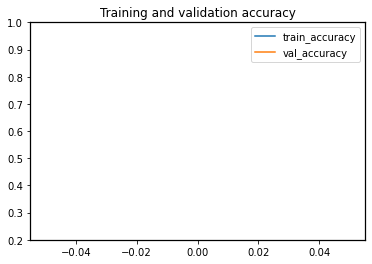

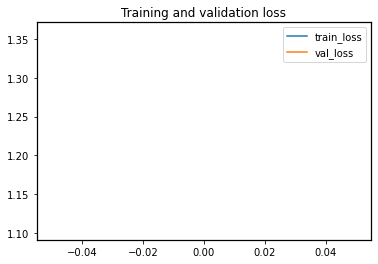

1/1 [==============================] - 2s 2s/step - loss: 1.0967 - accuracy: 0.4537

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
3/3 [==============================] - 15s 4s/step - loss: 1.3454 - accuracy: 0.3819 - val_loss: 1.0719 - val_accuracy: 0.3333

Epoch 00001: val_loss improved from -inf to 1.07186, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_2.h5


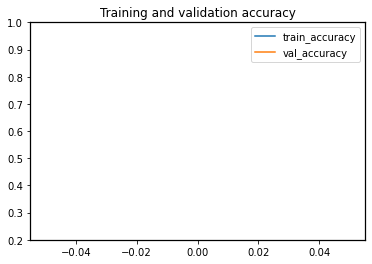

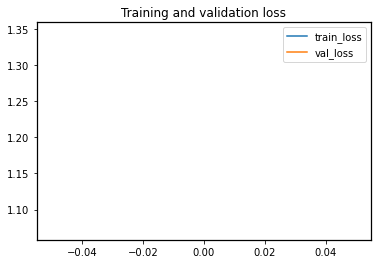

1/1 [==============================] - 3s 3s/step - loss: 1.0603 - accuracy: 0.3519

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
3/3 [==============================] - 17s 4s/step - loss: 1.6860 - accuracy: 0.2824 - val_loss: 1.3640 - val_accuracy: 0.3333

Epoch 00001: val_loss improved from -inf to 1.36402, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_3.h5


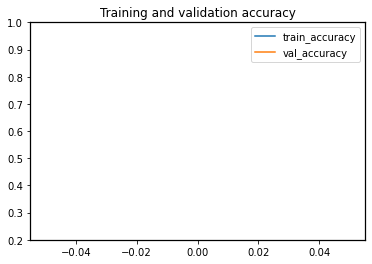

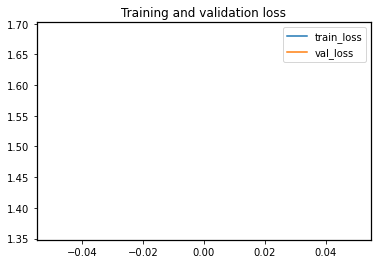

1/1 [==============================] - 3s 3s/step - loss: 1.3587 - accuracy: 0.3426

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
3/3 [==============================] - 17s 6s/step - loss: 1.2211 - accuracy: 0.4444 - val_loss: 1.4540 - val_accuracy: 0.3333

Epoch 00001: val_loss improved from -inf to 1.45395, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_4.h5


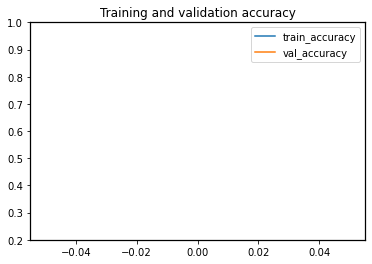

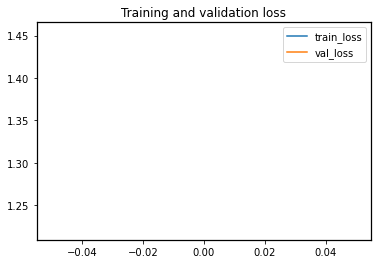

1/1 [==============================] - 3s 3s/step - loss: 1.4308 - accuracy: 0.3333

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
3/3 [==============================] - 19s 6s/step - loss: 1.5361 - accuracy: 0.3032 - val_loss: 1.6557 - val_accuracy: 0.3333

Epoch 00001: val_loss improved from -inf to 1.65568, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_5.h5


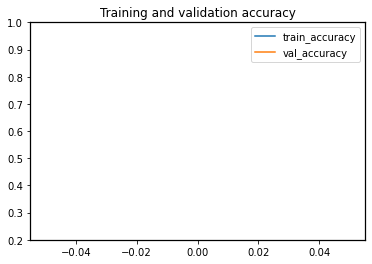

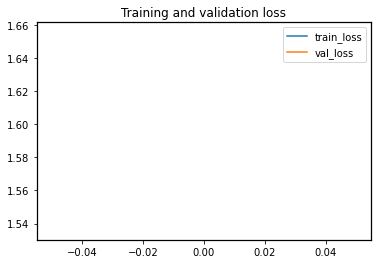

1/1 [==============================] - 3s 3s/step - loss: 1.6457 - accuracy: 0.3333

batch size:  200
epochs:  2
learning rate:  0.0001


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/2
3/3 [==============================] - 17s 6s/step - loss: 1.3496 - accuracy: 0.3657 - val_loss: 1.7983 - val_accuracy: 0.3333

Epoch 00001: val_loss improved from -inf to 1.79832, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_1.h5
Epoch 2/2
3/3 [==============================] - 10s 3s/step - loss: 1.1165 - accuracy: 0.4560 - val_loss: 1.7451 - val_accuracy: 0.3333

Epoch 00002: val_loss did not improve from 1.79832


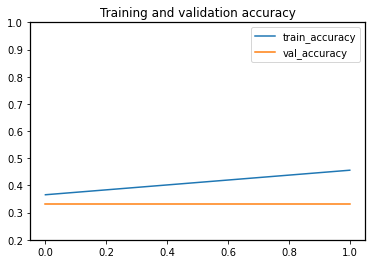

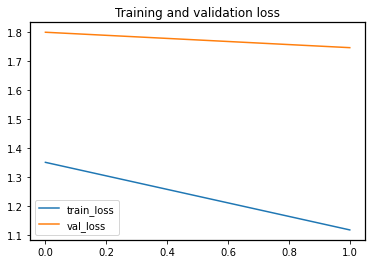

1/1 [==============================] - 3s 3s/step - loss: 1.7658 - accuracy: 0.3333

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/2
3/3 [==============================] - 18s 4s/step - loss: 1.5682 - accuracy: 0.3866 - val_loss: 1.5225 - val_accuracy: 0.4259

Epoch 00001: val_loss improved from -inf to 1.52253, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_2.h5
Epoch 2/2
3/3 [==============================] - 11s 3s/step - loss: 1.1396 - accuracy: 0.4699 - val_loss: 1.4300 - val_accuracy: 0.4074

Epoch 00002: val_loss did not improve from 1.52253


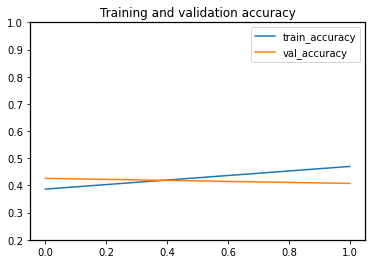

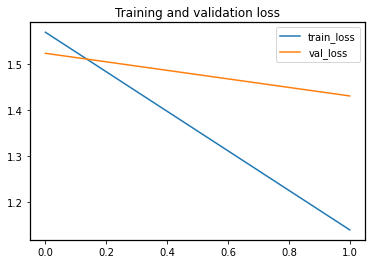

1/1 [==============================] - 3s 3s/step - loss: 1.5222 - accuracy: 0.4167

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/2
3/3 [==============================] - 20s 6s/step - loss: 1.2235 - accuracy: 0.4398 - val_loss: 1.0398 - val_accuracy: 0.4630

Epoch 00001: val_loss improved from -inf to 1.03983, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_3.h5
Epoch 2/2
3/3 [==============================] - 10s 5s/step - loss: 0.9746 - accuracy: 0.5370 - val_loss: 0.9911 - val_accuracy: 0.5000

Epoch 00002: val_loss did not improve from 1.03983


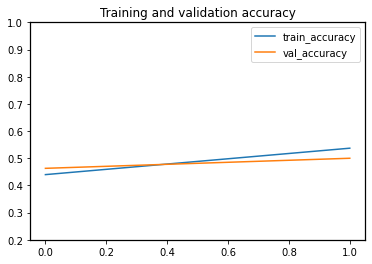

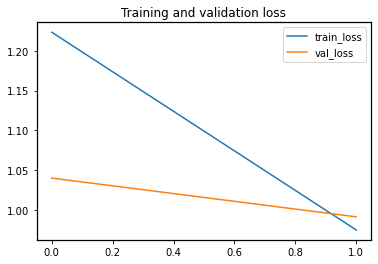

1/1 [==============================] - 2s 2s/step - loss: 1.0179 - accuracy: 0.4907

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/2
3/3 [==============================] - 15s 4s/step - loss: 1.5093 - accuracy: 0.3380 - val_loss: 1.2447 - val_accuracy: 0.4074

Epoch 00001: val_loss improved from -inf to 1.24470, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_4.h5
Epoch 2/2
3/3 [==============================] - 11s 3s/step - loss: 1.0802 - accuracy: 0.5255 - val_loss: 1.1501 - val_accuracy: 0.4537

Epoch 00002: val_loss did not improve from 1.24470


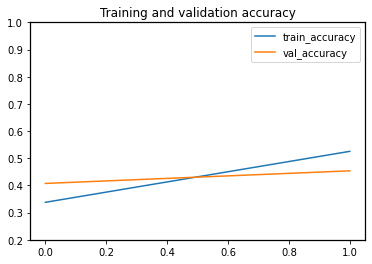

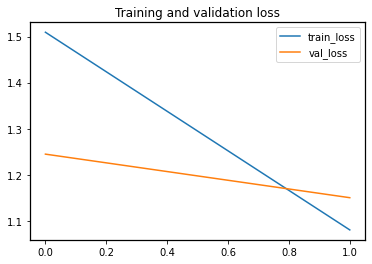

1/1 [==============================] - 3s 3s/step - loss: 1.2632 - accuracy: 0.3981

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/2
3/3 [==============================] - 17s 7s/step - loss: 1.2692 - accuracy: 0.4444 - val_loss: 1.1396 - val_accuracy: 0.4074

Epoch 00001: val_loss improved from -inf to 1.13956, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_5.h5
Epoch 2/2
3/3 [==============================] - 11s 3s/step - loss: 1.0306 - accuracy: 0.5116 - val_loss: 1.0813 - val_accuracy: 0.3519

Epoch 00002: val_loss did not improve from 1.13956


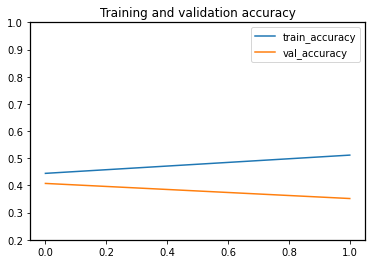

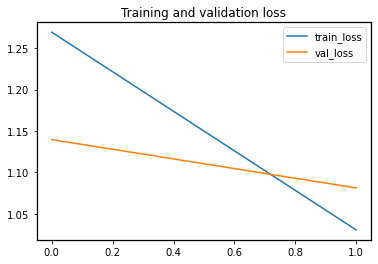

1/1 [==============================] - 3s 3s/step - loss: 1.1534 - accuracy: 0.3519


In [21]:
for x in range(len(batch_size_arr)):
    
    #for batch size values
    if len(param_arr) == 0:
        param_arr.append([])
    
    for y in range(len(num_epochs_arr)):

        #for epoch values
        if len(param_arr) == 1:
            param_arr.append([])
        
        for z in range(len(lr_arr)):
            
            #for learning rate values
            if len(param_arr) == 2:
                param_arr.append([])
               
            print('')
            print("batch size: ", batch_size_arr[x])
            print("epochs: ", num_epochs_arr[y])
            print("learning rate: ", lr_arr[z])
            print('')
            
            #append the values per combo
            param_arr[0].append(batch_size_arr[x])
            param_arr[1].append(num_epochs_arr[y])
            param_arr[2].append(lr_arr[z])
            
            VALIDATION_ACCURACY = []
            VALIDATION_LOSS = []
            
            TRAIN_ACCURACY = []
            TRAIN_LOSS = []
            
            #change save_dir value per combination
            save_dir = savemodel()
            fold_var = 1
            
            for train_index, val_index in skf.split(np.zeros(len(df2)),Y):
                
                #continuously split the dataset to train set and validation set in n folds
                training_data = df2.iloc[train_index]
                validation_data = df2.iloc[val_index]
                
                print('')
                print("Fold number " + str(fold_var))
                
                #apply data augmentation to both train set and validation set
                train_data_generator = imgdatagen.flow_from_dataframe(training_data, directory = train_dir,
                                       x_col = "filename", y_col = "label",
                                       class_mode = "categorical", target_size = (224,224), batch_size = batch_size_arr[x],
                                            shuffle = True)
                valid_data_generator  = imgdatagen.flow_from_dataframe(validation_data, directory = train_dir,
                                        x_col = "filename", y_col = "label",
                                        class_mode = "categorical", target_size = (224,224), batch_size = batch_size_arr[x],
                                            shuffle = True)
                
                #use the created model
                full_model = create_model()
                
                #compile the model
                full_model.compile(loss='categorical_crossentropy',
                              optimizer=keras.optimizers.Adamax(learning_rate=lr_arr[z]),
                              metrics=['accuracy']) #categorical_crossentropy cause it is more than 2 classes

                #create callbacks
                checkpoint = tf.keras.callbacks.ModelCheckpoint((save_dir+"/"+ "model_" + str(fold_var) + ".h5"), 
                                        monitor='val_loss', verbose=1, 
                                        save_best_only=True, mode='max')
                callbacks_list = [checkpoint]
                #this saves the best model


                #fit the model
                history = full_model.fit(train_data_generator,
                                         epochs=num_epochs_arr[y],
                                         callbacks=callbacks_list,
                                         validation_data=valid_data_generator,
                                         verbose=1)

                #plot the history
                plot_history(history, yrange=(0.2,1))

                #load the best model instance to evaluate the performance of the model
                full_model.load_weights(save_dir+"/model_"+str(fold_var)+".h5")

                results = full_model.evaluate(valid_data_generator)
                results = dict(zip(full_model.metrics_names,results))
                
                #store Validation accuracy/loss
                VALIDATION_ACCURACY.append(results['accuracy'])
                VALIDATION_LOSS.append(results['loss'])
                
                #store Train accuracy/loss
                TRAIN_ACCURACY.append(np.mean(history.history['accuracy']))
                TRAIN_LOSS.append(np.mean(history.history['loss']))
                
                tf.keras.backend.clear_session()

                fold_var += 1
            
            #store the all accuracy and loss in all folds per combination
            val_acc_arr.append(VALIDATION_ACCURACY)
            val_loss_arr.append(VALIDATION_LOSS)
            
            train_acc_arr.append(TRAIN_ACCURACY)                            
            train_loss_arr.append(TRAIN_LOSS)

In [22]:
#stopper

### Display Values Per Combination of Hyperparameters

We will put the combination of hyperparameters and the resulting means of accuracy and loss together in a dataframe in order to display it nicely.

In [23]:
#append means of accuracy and loss per combo
for x in range(len(val_acc_arr)):
    val_acc_means.append(np.mean(val_acc_arr[x]))                                
    val_loss_means.append(np.mean(val_loss_arr[x]))
    
    train_acc_means.append(np.mean(train_acc_arr[x]))                              
    train_loss_means.append(np.mean(train_loss_arr[x]))                             
    
df_hyperparam = pd.DataFrame(list(zip(param_arr[0],param_arr[1],param_arr[2],
                                      train_acc_means, train_loss_means,
                                      val_acc_means,val_loss_means))
                             ,columns=['batch size','number of epoch', 'learning rate', 
                                       'train accuracy', 'train loss',
                                       'val accuracy', 'val loss'])

df_hyperparam = df_hyperparam.sort_values(ascending=True,by = 'val loss')

#df_hyperparam.to_excel("hyperparam_result.xlsx")

df_hyperparam

,batch size,number of epoch,learning rate,train accuracy,train loss,val accuracy,val loss
0,200,1,0.0001,0.353241,1.429422,0.362963,1.318434
1,200,2,0.0001,0.447454,1.226110,0.398148,1.344489


In [24]:
#stopper

### Each fold results of best combination

Below are the validation accuracy and validation loss per fold and their average of the best combination.

In [25]:
#get the index of the best combination
comb_no = df_hyperparam.loc[[df_hyperparam['val loss'].idxmin()]].index.tolist()[0]
fold_num = [*range(1,6)]

fold_eval = pd.DataFrame(list(zip(fold_num,train_acc_arr[comb_no],train_loss_arr[comb_no],
                                  val_acc_arr[comb_no],val_loss_arr[comb_no]))
                         ,columns=['fold','Training Accuracy','Training Loss',
                                   'Validation Accuracy','Validation Loss'])

fold_eval.set_index('fold', inplace=True)
fold_eval.loc['mean'] = fold_eval.mean()

#fold_eval.to_excel('fold_eval.xlsx')
fold_eval

,Training Accuracy,Training Loss,Validation Accuracy,Validation Loss
fold,,,,
1,0.354167,1.358503,0.453704,1.096673
2,0.381944,1.345360,0.351852,1.060297
3,0.282407,1.686034,0.342593,1.358678
4,0.444444,1.221070,0.333333,1.430809
5,0.303241,1.536144,0.333333,1.645713
mean,0.353241,1.429422,0.362963,1.318434


In [26]:
#stopper

## Final Model

We will use the best combination of hypaparameters to train our final model. We will evaluate the model using the train set.

### Get best combination of hyperparameters

In [27]:
df_bestohypaparamu = df_hyperparam.loc[[df_hyperparam['val loss'].idxmin()]]

bestohypaparamu = [df_bestohypaparamu['batch size'].values[0],
                   df_bestohypaparamu['number of epoch'].values[0],
                   df_bestohypaparamu['learning rate'].values[0]]

### Split Train Set to Train Set and Validation Set

The same as to what was done in the hyperparameter tuning, we will split the train set to train and validation set with the same random state of 69 in order to have a similar resulting accuracy and loss.

In [28]:
# Split train set to train set and valid set
X = df2[['filename']]
y = df2[['label']]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

We will save the images from the new train set and validation set to separate folders.

In [29]:
#folder to store the train and test set folders
fortraintest2 = directory + "/ToBeUsedFinalModel"
if not os.path.exists(fortraintest2):
    os.makedirs(fortraintest2)

#train set folder
tr2 = fortraintest2 + "/train_set"
if not os.path.exists(tr2):
    os.makedirs(tr2)
else:
    #remove previous folder and create new one
    shutil.rmtree(tr2)
    os.makedirs(tr2)
    
#test set folder
va = fortraintest2 + "/val_set"
if not os.path.exists(va):
    os.makedirs(va)
else:
    #remove previous folder and create new one
    shutil.rmtree(va)
    os.makedirs(va)

#copying the images to the train set folder
for index, row in X_train.iterrows():
    try:
        trcpy = shutil.copy2(row['filename'], tr2)
    except shutil.SameFileError:
        pass
    
    X_train.loc[X_train['filename']==row['filename'],'filename']=trcpy #change to directory where image is copied
    
#copying the images to the test set folder
for index, row in X_val.iterrows():
    try:
        vacpy = shutil.copy2(row['filename'], va)
    except shutil.SameFileError:
        pass
    
    X_val.loc[X_val['filename']==row['filename'],'filename']=vacpy #change to directory where image is copied

### Train Set Final Model

In [30]:
df4 = pd.concat([X_train,y_train],axis=1)
df4

,filename,label
547,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,2
382,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,1
218,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,1
549,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,2
468,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,2
...,...,...
322,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,1
269,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,1
127,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,0
442,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,2


In [31]:
counto = [0,0,0]

counto_count = 0

df4_lbl = sorted(df4['label'].unique(), reverse=False) 

for x in df4_lbl:
    for y in df4['label']:
        if x == y:
            if counto_count == 0:
                counto[0] += 1
            elif counto_count == 1:
                counto[1] += 1
            else:
                counto[2] += 1
                
    counto_count += 1
    
print(counto)

[144, 144, 144]


### Validation Set Final Model

In [32]:
df5 = pd.concat([X_val,y_val],axis=1)
df5

,filename,label
420,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,2
27,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,0
240,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,1
306,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,1
354,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,1
...,...,...
34,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,0
199,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,0
336,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,1
67,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,0


In [33]:
counto = [0,0,0]

counto_count = 0

df5_lbl = sorted(df5['label'].unique(), reverse=False) 

for x in df5_lbl:
    for y in df5['label']:
        if x == y:
            if counto_count == 0:
                counto[0] += 1
            elif counto_count == 1:
                counto[1] += 1
            else:
                counto[2] += 1
                
    counto_count += 1
    
print(counto)

[36, 36, 36]


### Train the Final Model

We will now train the final model.

Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
3/3 [==============================] - 22s 8s/step - loss: 1.2384 - accuracy: 0.4167 - val_loss: 1.3231 - val_accuracy: 0.3333

Epoch 00001: val_loss improved from -inf to 1.32313, saving model to C:/Users/user/Desktop/Model/saved_finalmodel_1\finalmodel_1.h5


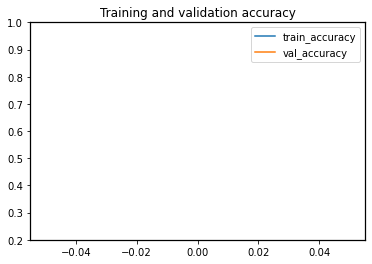

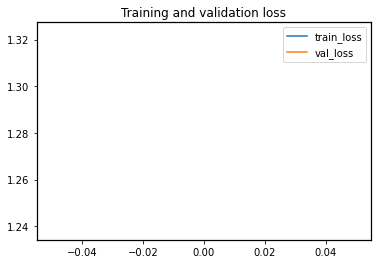

1/1 [==============================] - 3s 3s/step - loss: 1.2699 - accuracy: 0.3333


In [34]:
VAL_ACCURACY = None
VAL_LOSS = None

train_dir = tr2
valid_dir = va
save_dir = gen_dir + "/saved_finalmodel_1"

if os.path.exists(save_dir):
    shutil.rmtree(save_dir)
    
os.makedirs(save_dir)

trainu = df4
validu = df5

train_data_generator = imgdatagen.flow_from_dataframe(trainu, directory = train_dir,
                                       x_col = "filename", y_col = "label",
                                       class_mode = "categorical", target_size = (224,224), batch_size = bestohypaparamu[0],
                                            shuffle = True)
valid_data_generator  = imgdatagen.flow_from_dataframe(validu, directory = valid_dir,
                        x_col = "filename", y_col = "label",
                        class_mode = "categorical", target_size = (224,224), batch_size = bestohypaparamu[0],
                            shuffle = True)

#print(len(train_data_generator))

full_model = create_model()
# Compile the model
full_model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adamax(learning_rate=bestohypaparamu[2]),
              metrics=['accuracy']) #categorical_crossentropy cause it is more than 2 classes

# Create callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint((save_dir+"/"+ "finalmodel_1.h5"), 
                        monitor='val_loss', verbose=1, 
                        save_best_only=True, mode='max')
callbacks_list = [checkpoint]
# This saves the best model


# Fit the model
history = full_model.fit(train_data_generator,
                         epochs=bestohypaparamu[1],
                         callbacks=callbacks_list,
                         validation_data=valid_data_generator,
                         verbose=1)

# Plot the history
plot_history(history, yrange=(0.2,1))

# Load the best model instance to evaluate the performance of the model
full_model.load_weights(save_dir+"/"+ "finalmodel_1.h5")

results = full_model.evaluate(valid_data_generator)

#print(results)

results = dict(zip(full_model.metrics_names,results))

# Store Validation accuracy/loss
VAL_ACCURACY = results['accuracy']
VAL_LOSS = results['loss']

tf.keras.backend.clear_session()

Display the validation accuracy and loss.

In [35]:
print("Val acc:  " + str(VAL_ACCURACY))
print("Val loss: " + str(VAL_LOSS))

Val acc:  0.3333333432674408
Val loss: 1.2699230909347534


### Predict Using Test Set

Test set is used in order to do model prediction.

In [36]:
#to get the test set images convert the image to numpy array and store to testX
testX = []

for img_path in X_test['filename']:
    img = im.load_img(img_path, target_size=(224,224))
    x = im.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = x.reshape(224,224,3)
    testX.append(x)

testX = np.array(testX)

In [37]:
save_dir = gen_dir + "/saved_finalmodel_1"
full_model = create_model()
full_model.load_weights(save_dir+"/"+ "finalmodel_1.h5")

# Needed later for measuring performance metrics
# Predict test set to get the test accuracy/loss
yhat_probs2 = full_model.predict(testX, verbose=0) 
yhat_classes2 = yhat_probs2.argmax(axis=-1)

## Measure Performance Metrics

After we have trained the final model with the entire train set and done prediction using the test set, we can now measure the performance metrics for model evaluation.

In [38]:
yt = pd.to_numeric(y_test['label'])                #make the labels to integer to get the model metrics

## Functions

### Accuracy, Precision, Recall

In [39]:
def metriksu(yhat_classes2):
    
    # accuracy: (tp + tn) / (p + n)
    matrix = confusion_matrix(yt, yhat_classes2)
    accuracy2 = matrix.diagonal()/matrix.sum(axis=1)
    print('Accuracy per class: ' + str(accuracy2))
    # precision tp / (tp + fp)
    precision = precision_score(yt, yhat_classes2, average="weighted")
    print('Precision: %f' % precision)
    precision2 = precision_score(yt, yhat_classes2, average=None)
    print('Precision per class: ' + str(precision2))
    # recall: tp / (tp + fn)
    recall = recall_score(yt, yhat_classes2, average="weighted")
    print('Recall: %f' % recall)
    recall2 = recall_score(yt, yhat_classes2, average=None)
    print('Recall per class: ' + str(recall2))
    
    return accuracy2, precision2, recall2

### ROC AUC

In [40]:
def roshi_aushi(yhat_probs2):
    
    # Binarize the true label
    ytbin = label_binarize(yt, classes=[0, 1, 2])
    n_classes = ytbin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
      
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytbin[:, i], yhat_probs2[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i]) 

    # Compute micro-average ROC curve and ROC area
    fpr["macro"], tpr["macro"], _ = roc_curve(ytbin.ravel(), yhat_probs2.ravel())
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams["axes.edgecolor"] = 'black'
    plt.rcParams["axes.linewidth"]  = 1.25
    
    #balut-penoy
    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Balut-Penoy')
    plt.legend(loc="lower right")
    plt.show()

    #salted egg
    plt.figure()
    lw = 2
    plt.plot(fpr[1], tpr[1], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Salted Egg')
    plt.legend(loc="lower right")
    plt.show()

    #table egg
    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Table Egg')
    plt.legend(loc="lower right")
    plt.show()

### Confusion Matrix

In [41]:
def confuuusion_meytriksu(yhat_classes2):

    #confusion matrix
    matrix = confusion_matrix(yt, yhat_classes2)
    
    df_cm = pd.DataFrame(matrix, range(matrix.shape[0]), range(matrix.shape[1]))
    df_cm = df_cm.rename(columns={0:'Balut/Penoy', 1:'Salted Egg', 2:'Table Egg'}, 
                         index={0:'Balut/Penoy', 1:'Salted Egg', 2:'Table Egg'})
    
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title('Confusion Matrix of Final Model Evaluation')

Call all the functions.

In [42]:
accuracy2, precision2, recall2 = metriksu(yhat_classes2)

Accuracy per class: [1. 0. 0.]
Precision: 0.111111
Precision per class: [0.33333333 0.         0.        ]
Recall: 0.333333
Recall per class: [1. 0. 0.]


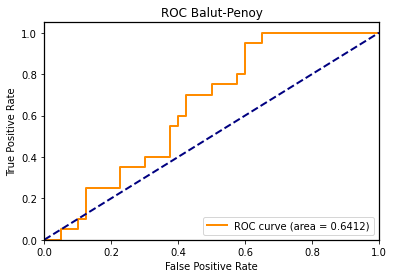

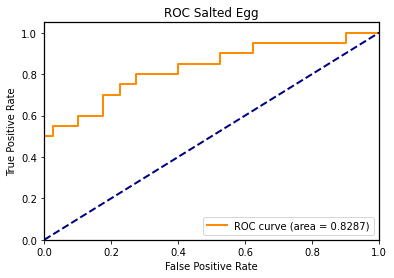

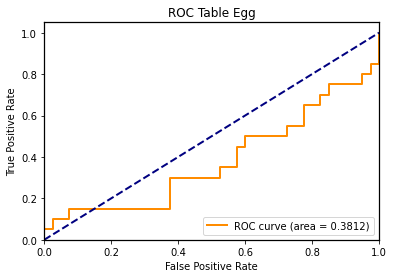

In [43]:
roshi_aushi(yhat_probs2)

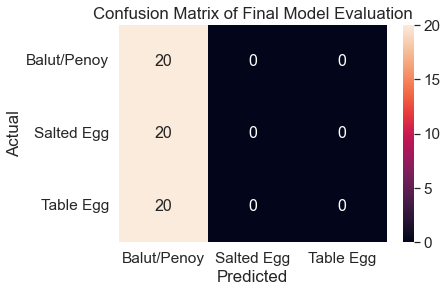

In [44]:
confuuusion_meytriksu(yhat_classes2)

### Metrics per Class

In [45]:
accuracy2 = list(accuracy2)
precision2 = list(precision2)
recall2 = list(recall2)

accuracy2.append(0)
precision2.append(0)
recall2.append(0)

classes = 3

for x in range(classes):
    accuracy2[-1] += accuracy2[x]
    precision2[-1] += precision2[x]
    recall2[-1] += recall2[x]

accuracy2[-1] = accuracy2[-1]/classes
precision2[-1] = precision2[-1]/classes
recall2[-1] = recall2[-1]/classes

In [46]:
label = ['Balut/Penoy','Salted','Table','Ave']

df_eval_per_class = pd.DataFrame(data = list(zip(label,accuracy2,precision2,recall2)), 
                       columns=["Class","Accuracy","Precision","Recall"])

#set fold_ave as the index
df_eval_per_class.set_index("Class",inplace=True)

df_eval_per_class

,Accuracy,Precision,Recall
Class,,,
Balut/Penoy,1.000000,0.333333,1.000000
Salted,0.000000,0.000000,0.000000
Table,0.000000,0.000000,0.000000
Ave,0.333333,0.111111,0.333333


## Validating Misclassified Images

We will display the correct and incorrect predictions. We will first get the images from the directories stored under the filename column.

In [47]:
testX2 = []

for img_path in X_test['filename']:
    img = cv2.imread(img_path)
    testX2.append(img)

testX2 = np.array(testX2)

We will be applying Grad-CAM in order to check where is the focus of the model. It presents a heatmap. The hotter the color on a region is, the more it is focused on.

### Grad-CAM algorithm

In [48]:
last_conv_layer_name = "conv5_block3_add"

preprocess_input = keras.applications.resnet50.preprocess_input

def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

### superimposed visualization

In [49]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.5):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

### Prediction

In [50]:
def guraducamu(img_dir):
    img_size = (224,224)

    # Prepare image
    img_array = get_img_array(img_dir, img_size)

    conv_model = keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

    for layer in conv_model.layers:
        layer.trainable = False

    x = keras.layers.GlobalAveragePooling2D()(conv_model.output)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)
    predictions = keras.layers.Dense(3, activation='softmax',name = "prediction")(x)

    model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

    model.load_weights(save_dir+"/"+ "finalmodel_1.h5")

    # Remove last layer's softmax
    model.layers[-1].activation = None

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
 
    print("Original Image")
    display(Image(img_dir))

    print("Heatmap Prediction")
    plt.matshow(heatmap)
    plt.grid(False)
    plt.axis('off')
    plt.show()

    print("Grad-CAM")
    save_and_display_gradcam(img_dir, heatmap)

### Correct predictions

Found 20 correct labels
Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 79.jpg
Original Image


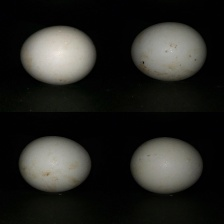

Heatmap Prediction


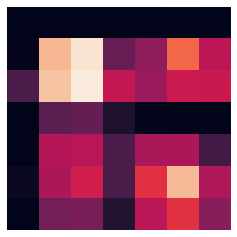

Grad-CAM


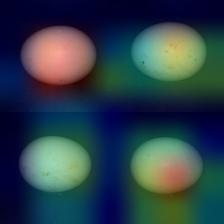

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 4.jpg
Original Image


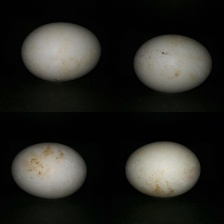

Heatmap Prediction


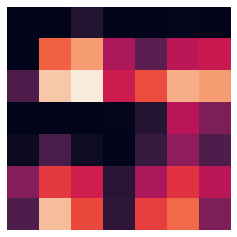

Grad-CAM


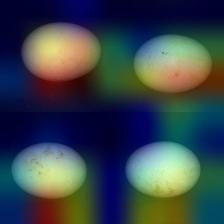

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 108.jpg
Original Image


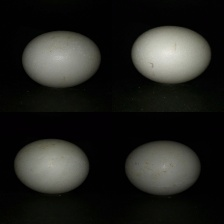

Heatmap Prediction


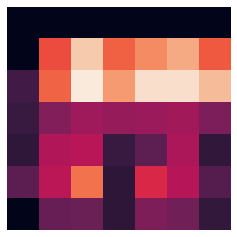

Grad-CAM


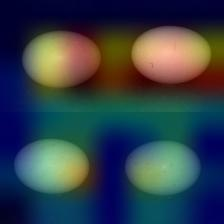

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 58.jpg
Original Image


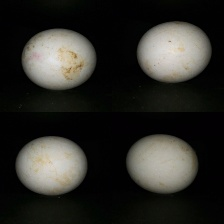

Heatmap Prediction


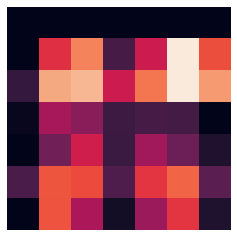

Grad-CAM


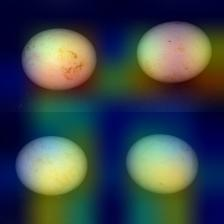

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 32.jpg
Original Image


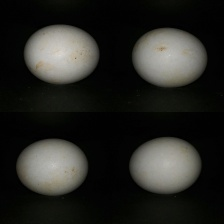

Heatmap Prediction


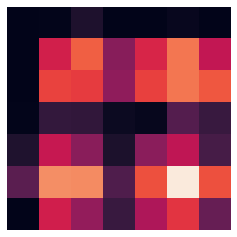

Grad-CAM


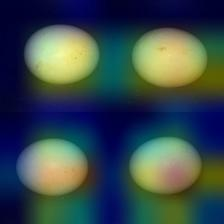

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 47.jpg
Original Image


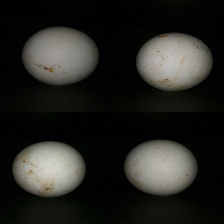

Heatmap Prediction


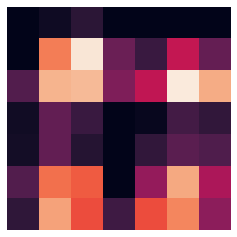

Grad-CAM


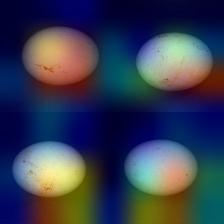

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 56.jpg
Original Image


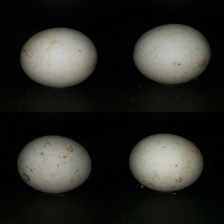

Heatmap Prediction


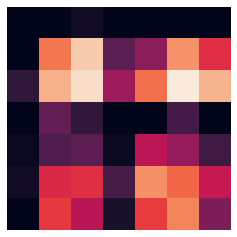

Grad-CAM


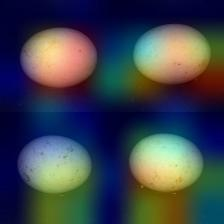

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 156.jpg
Original Image


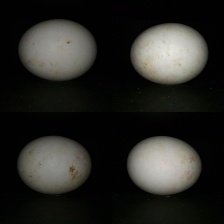

Heatmap Prediction


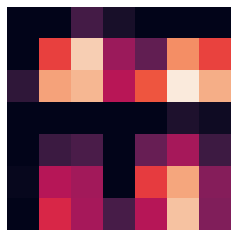

Grad-CAM


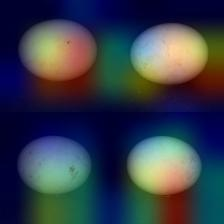

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 22.jpg
Original Image


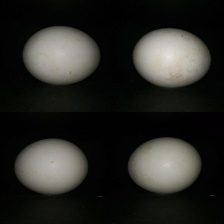

Heatmap Prediction


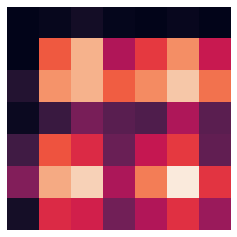

Grad-CAM


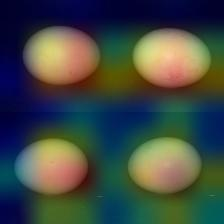

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 130.jpg
Original Image


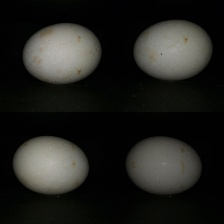

Heatmap Prediction


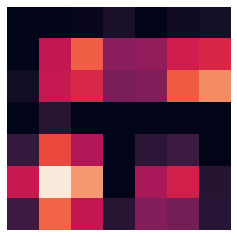

Grad-CAM


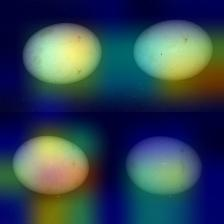

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 76.jpg
Original Image


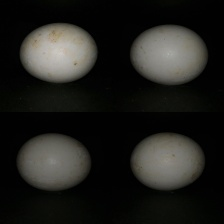

Heatmap Prediction


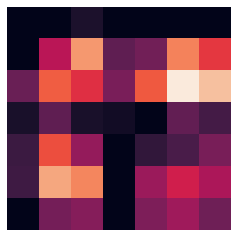

Grad-CAM


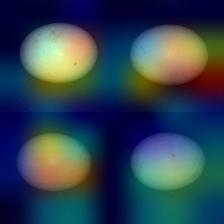

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 141.jpg
Original Image


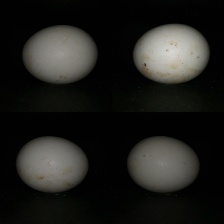

Heatmap Prediction


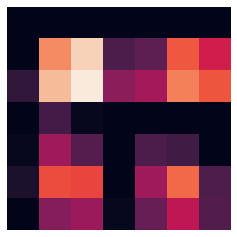

Grad-CAM


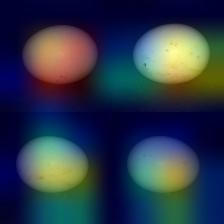

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 127.jpg
Original Image


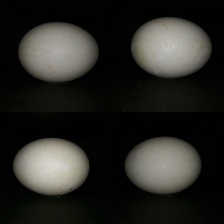

Heatmap Prediction


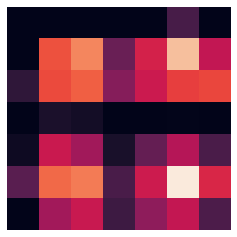

Grad-CAM


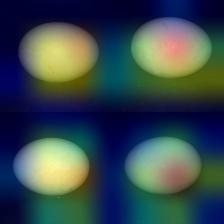

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 55.jpg
Original Image


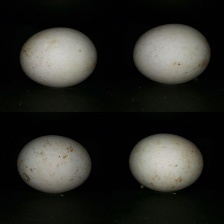

Heatmap Prediction


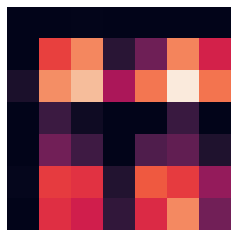

Grad-CAM


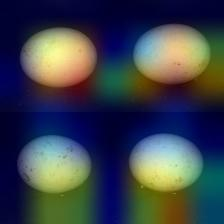

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 164.jpg
Original Image


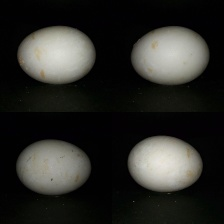

Heatmap Prediction


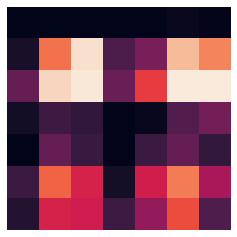

Grad-CAM


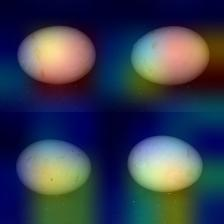

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 176.jpg
Original Image


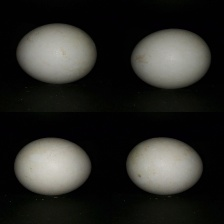

Heatmap Prediction


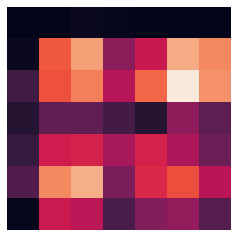

Grad-CAM


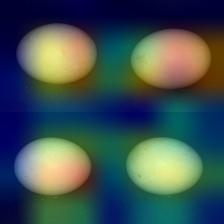

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 38.jpg
Original Image


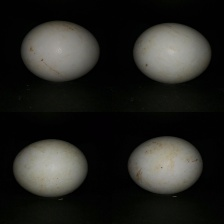

Heatmap Prediction


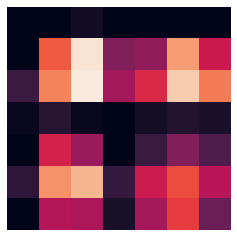

Grad-CAM


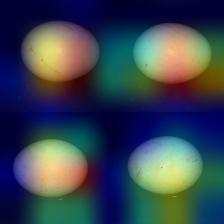

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 132.jpg
Original Image


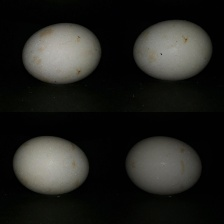

Heatmap Prediction


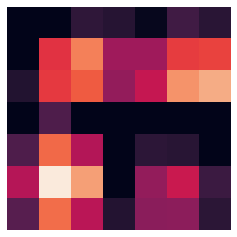

Grad-CAM


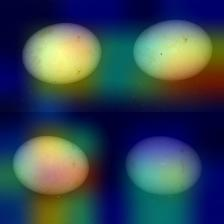

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 86.jpg
Original Image


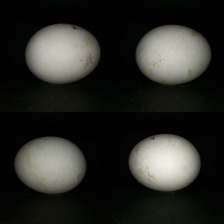

Heatmap Prediction


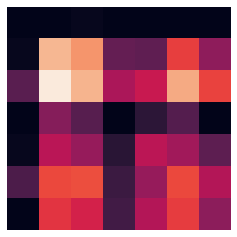

Grad-CAM


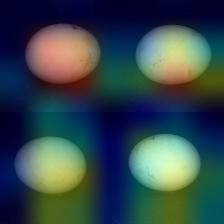

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 98.jpg
Original Image


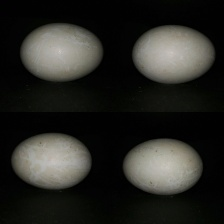

Heatmap Prediction


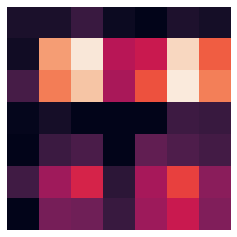

Grad-CAM


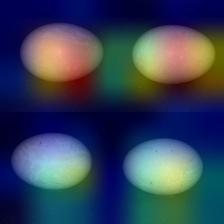

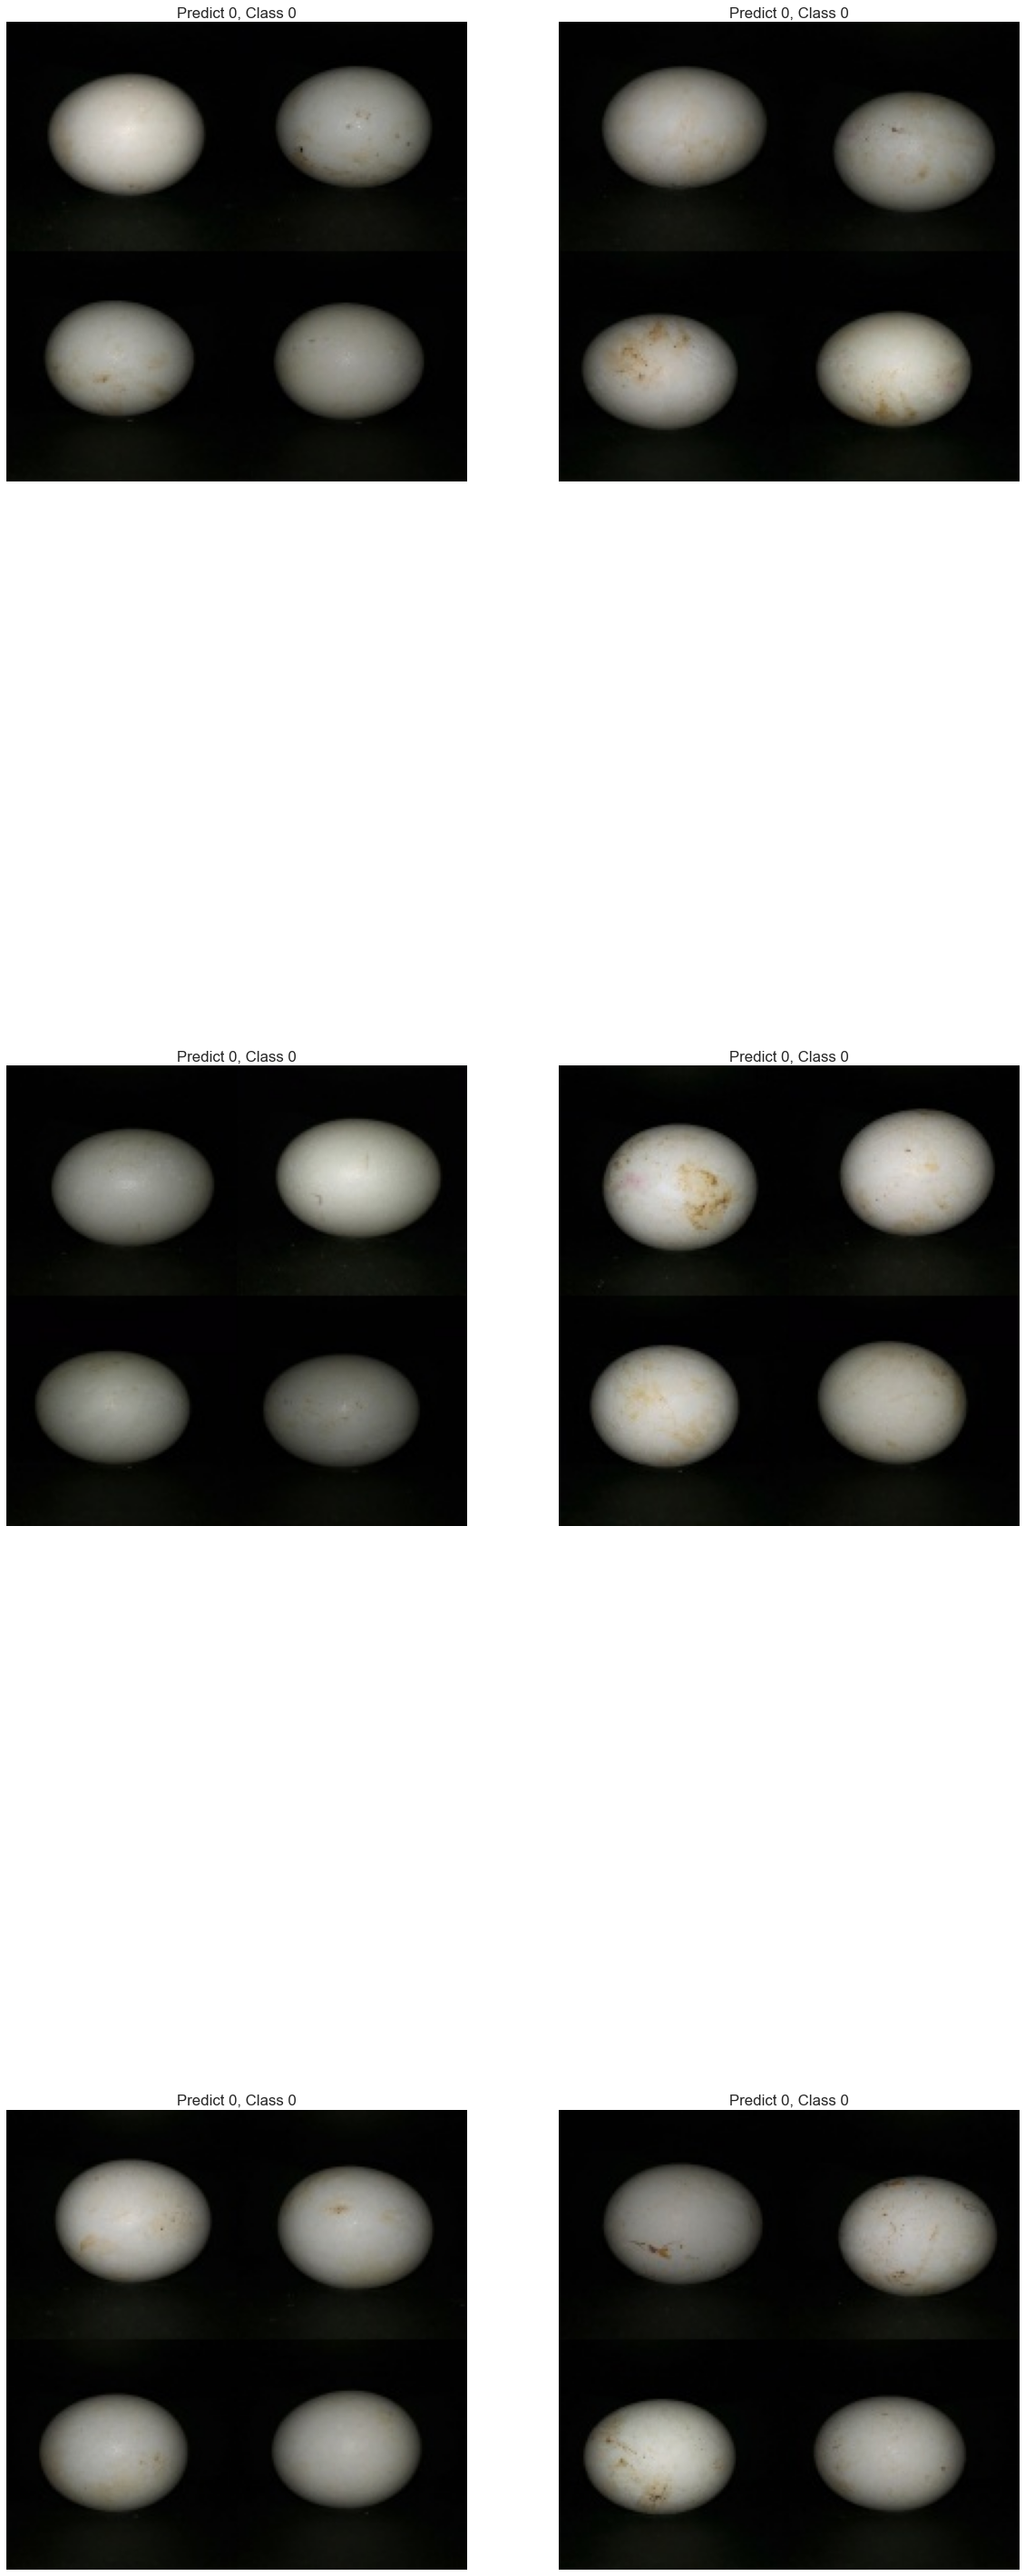

In [51]:
correct = np.where(yhat_classes2==yt)[0]

print("Found %d correct labels" % len(correct))

for x in correct:
    print("Predict {0}, Class {1}".format(str(yhat_classes2[x]),str(yt.values[x])))
    img_dir = X_test.iloc[x]['filename']
    print(img_dir)
    guraducamu(img_dir)
    
plt.figure(figsize=(20,60))
for i, correct in enumerate(correct[:6]):
    plt.subplot(3,2,i+1)
    RGB_img = cv2.cvtColor(testX2[correct], cv2.COLOR_BGR2RGB)
    plt.imshow(RGB_img) #, interpolation='none') #, cmap='gray')
    plt.title("Predict {0}, Class {1}".format(str(yhat_classes2[correct]),str(yt.values[correct])))
    plt.grid(False)
    plt.axis('off')

plt.show()

### Incorrect predictions

Found 40 incorrect labels
Predict 0, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg.peewee 40.jpg
Original Image


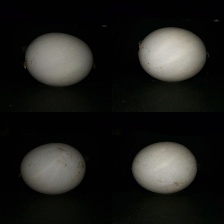

Heatmap Prediction


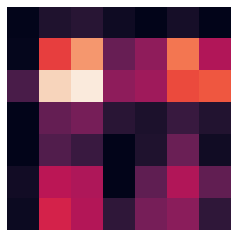

Grad-CAM


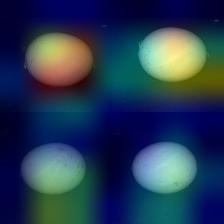

Predict 0, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg.peewee 66.jpg
Original Image


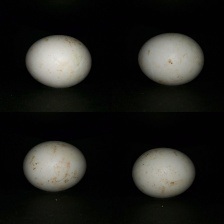

Heatmap Prediction


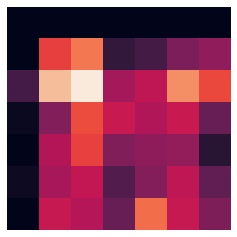

Grad-CAM


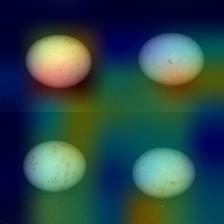

Predict 0, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg.broken crack 98.jpg
Original Image


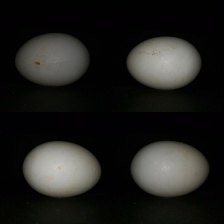

Heatmap Prediction


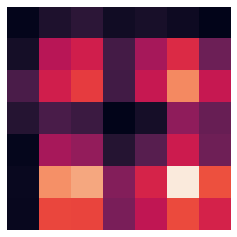

Grad-CAM


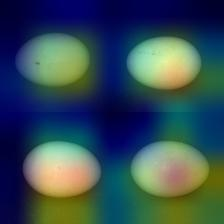

Predict 0, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg.peewee 100.jpg
Original Image


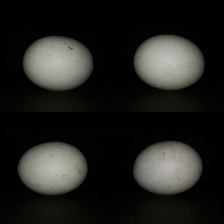

Heatmap Prediction


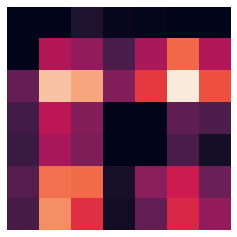

Grad-CAM


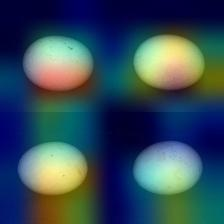

Predict 0, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg.dirty 61.jpg
Original Image


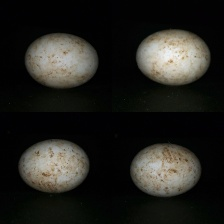

Heatmap Prediction


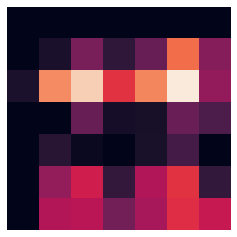

Grad-CAM


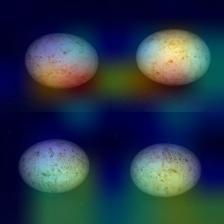

Predict 0, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg.peewee 62.jpg
Original Image


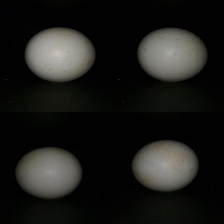

Heatmap Prediction


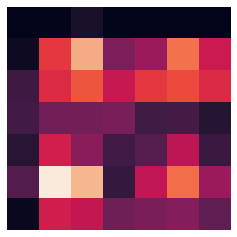

Grad-CAM


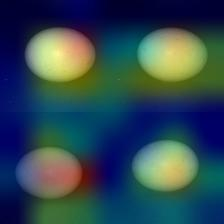

Predict 0, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg.hairline cracks 39.jpg
Original Image


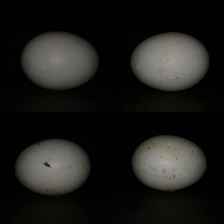

Heatmap Prediction


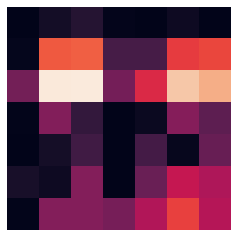

Grad-CAM


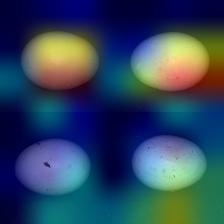

Predict 0, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg.small medium 23.jpg
Original Image


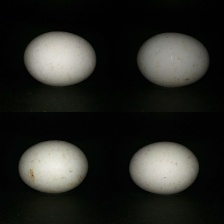

Heatmap Prediction


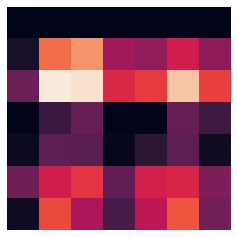

Grad-CAM


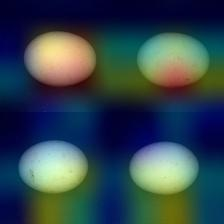

Predict 0, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg.hairline cracks 18.jpg
Original Image


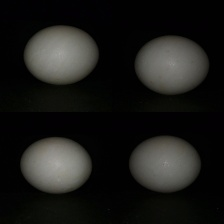

Heatmap Prediction


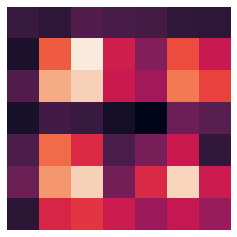

Grad-CAM


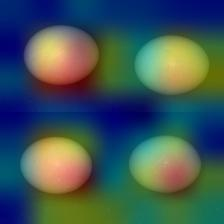

Predict 0, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg.small medium 30.jpg
Original Image


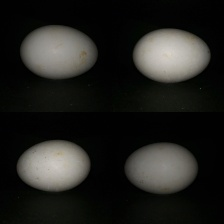

Heatmap Prediction


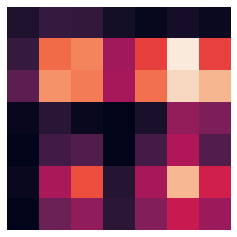

Grad-CAM


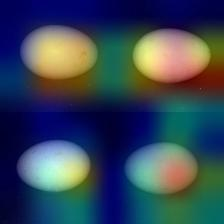

Predict 0, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg.broken crack 29.jpg
Original Image


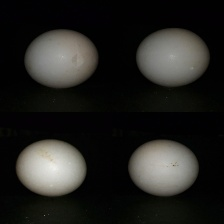

Heatmap Prediction


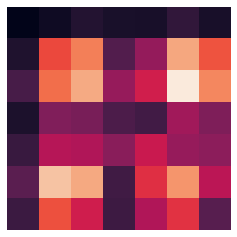

Grad-CAM


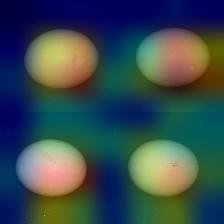

Predict 0, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg.broken crack 33.jpg
Original Image


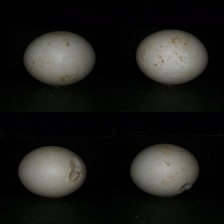

Heatmap Prediction


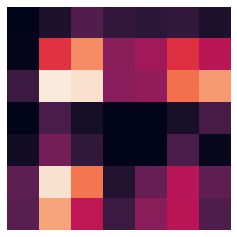

Grad-CAM


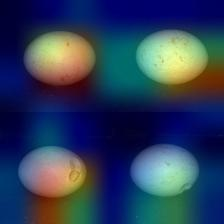

Predict 0, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg.small medium 35.jpg
Original Image


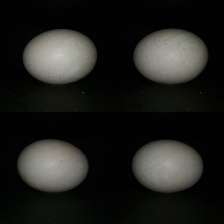

Heatmap Prediction


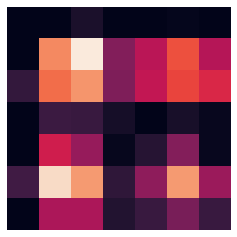

Grad-CAM


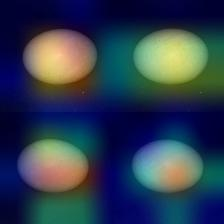

Predict 0, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg.hairline cracks 64.jpg
Original Image


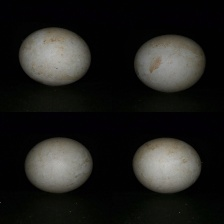

Heatmap Prediction


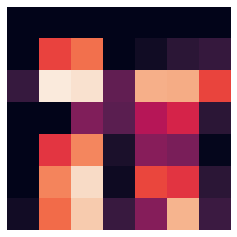

Grad-CAM


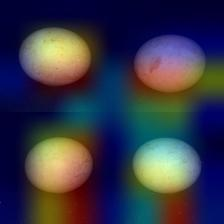

Predict 0, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg.broken crack 8.jpg
Original Image


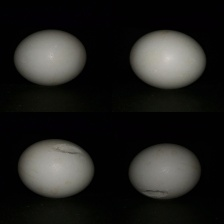

Heatmap Prediction


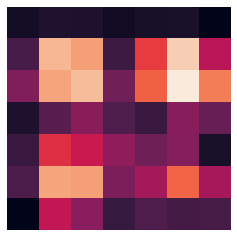

Grad-CAM


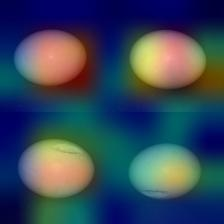

Predict 0, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg.peewee 14.jpg
Original Image


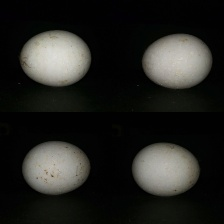

Heatmap Prediction


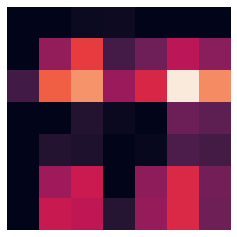

Grad-CAM


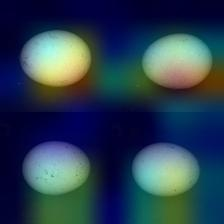

Predict 0, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg.hairline cracks 20.jpg
Original Image


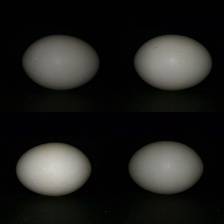

Heatmap Prediction


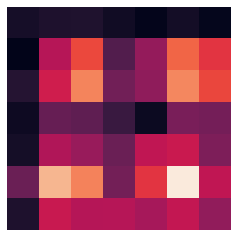

Grad-CAM


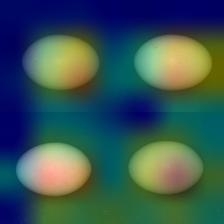

Predict 0, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg.broken crack 22.jpg
Original Image


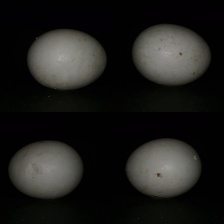

Heatmap Prediction


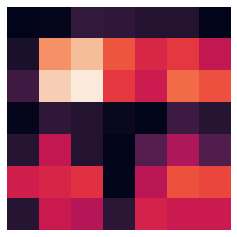

Grad-CAM


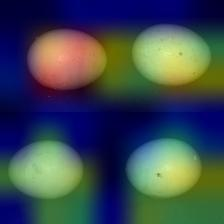

Predict 0, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg.dirty 14.jpg
Original Image


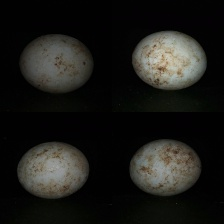

Heatmap Prediction


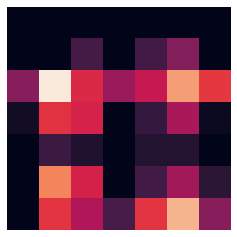

Grad-CAM


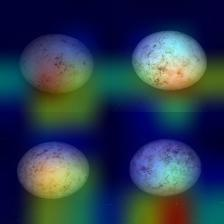

Predict 0, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg.peewee 42.jpg
Original Image


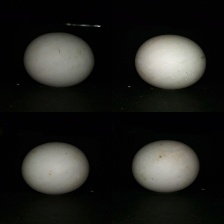

Heatmap Prediction


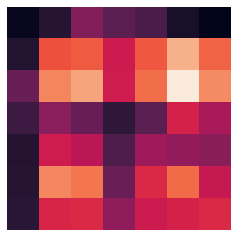

Grad-CAM


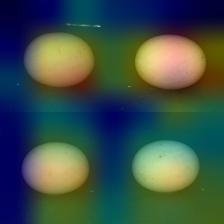

Predict 0, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg.peewee 8.jpg
Original Image


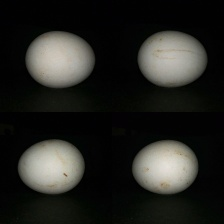

Heatmap Prediction


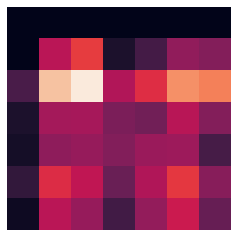

Grad-CAM


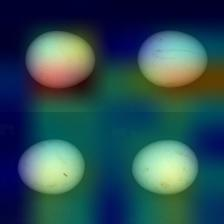

Predict 0, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg.dirty 66.jpg
Original Image


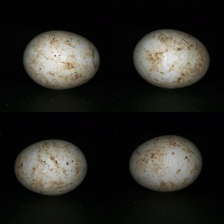

Heatmap Prediction


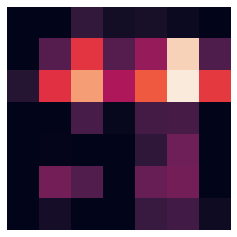

Grad-CAM


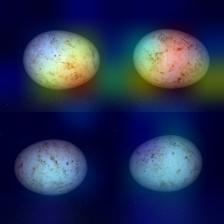

Predict 0, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg.hairline cracks 44.jpg
Original Image


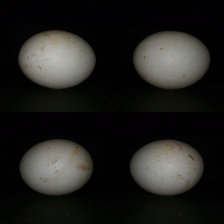

Heatmap Prediction


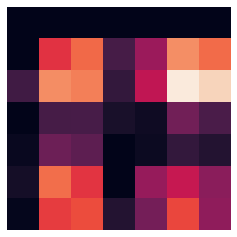

Grad-CAM


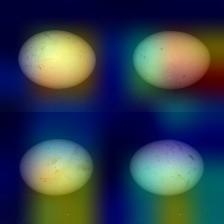

Predict 0, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg.small medium 64.jpg
Original Image


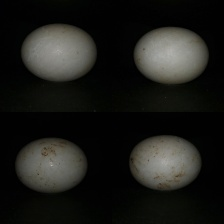

Heatmap Prediction


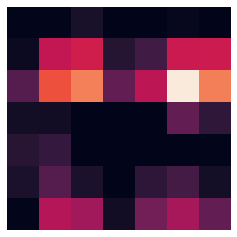

Grad-CAM


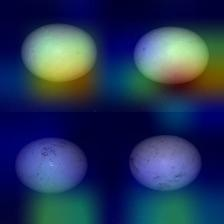

Predict 0, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg.hairline cracks 65.jpg
Original Image


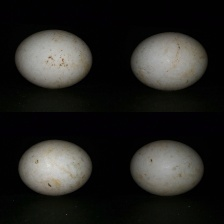

Heatmap Prediction


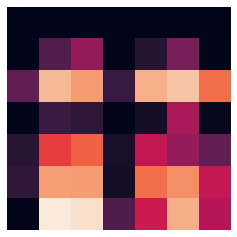

Grad-CAM


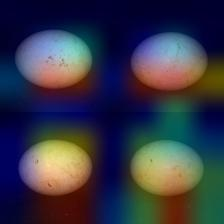

Predict 0, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg.dirty 44.jpg
Original Image


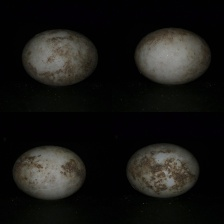

Heatmap Prediction


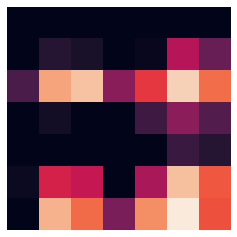

Grad-CAM


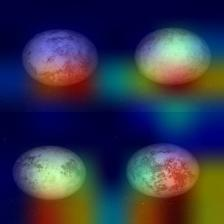

Predict 0, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg.dirty 49.jpg
Original Image


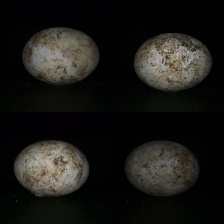

Heatmap Prediction


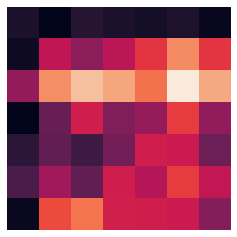

Grad-CAM


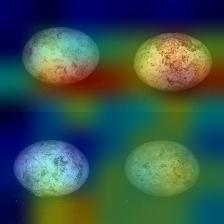

Predict 0, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg.broken crack 11.jpg
Original Image


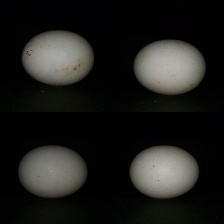

Heatmap Prediction


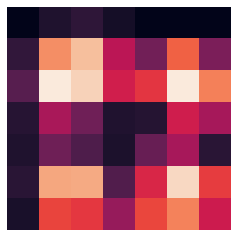

Grad-CAM


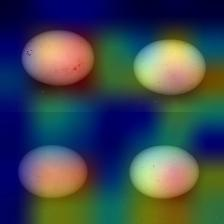

Predict 0, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg.hairline cracks 2.jpg
Original Image


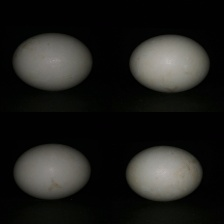

Heatmap Prediction


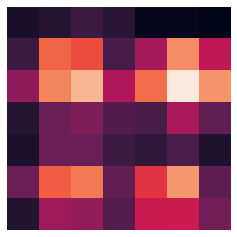

Grad-CAM


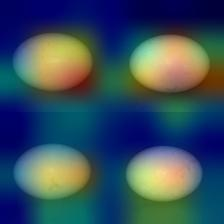

Predict 0, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg.peewee 49.jpg
Original Image


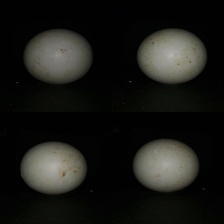

Heatmap Prediction


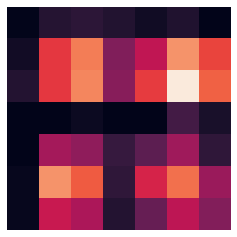

Grad-CAM


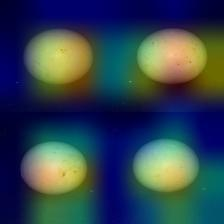

Predict 0, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg.peewee 39.jpg
Original Image


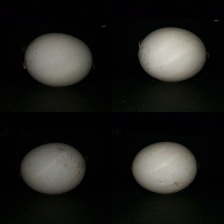

Heatmap Prediction


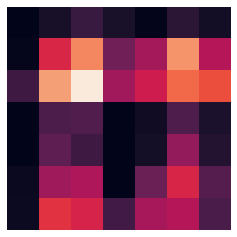

Grad-CAM


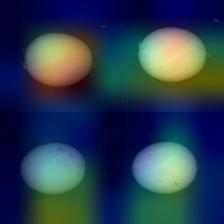

Predict 0, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg.peewee 25.jpg
Original Image


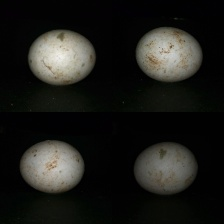

Heatmap Prediction


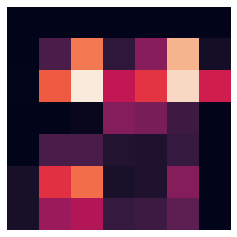

Grad-CAM


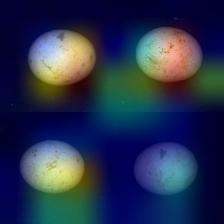

Predict 0, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg.dirty 21.jpg
Original Image


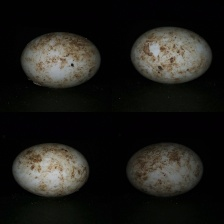

Heatmap Prediction


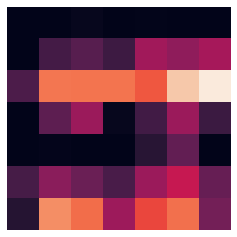

Grad-CAM


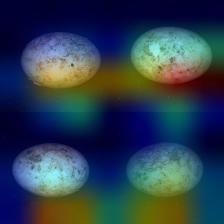

Predict 0, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg.dirty 28.jpg
Original Image


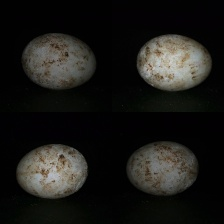

Heatmap Prediction


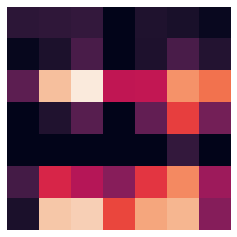

Grad-CAM


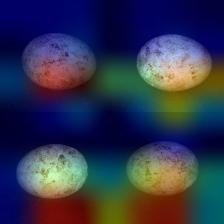

Predict 0, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg.small medium 25.jpg
Original Image


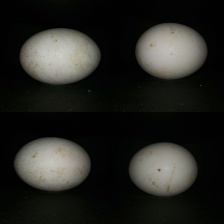

Heatmap Prediction


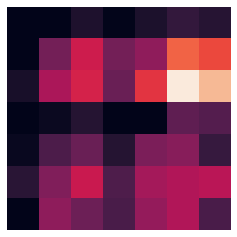

Grad-CAM


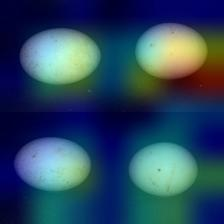

Predict 0, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg.broken crack 21.jpg
Original Image


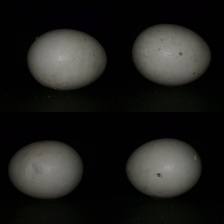

Heatmap Prediction


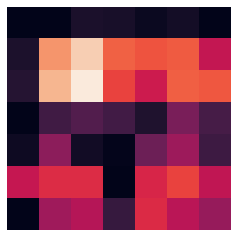

Grad-CAM


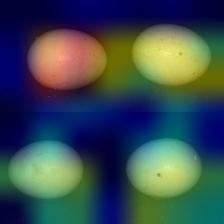

Predict 0, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg.peewee 71.jpg
Original Image


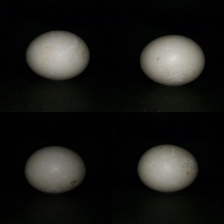

Heatmap Prediction


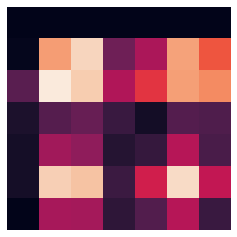

Grad-CAM


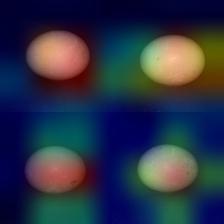

Predict 0, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg.broken crack 28.jpg
Original Image


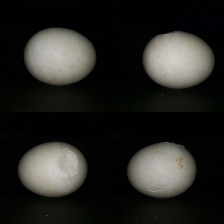

Heatmap Prediction


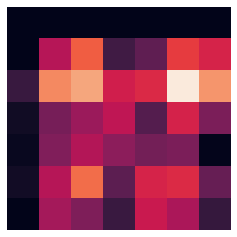

Grad-CAM


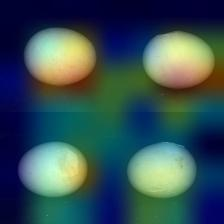

Predict 0, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg.peewee 24.jpg
Original Image


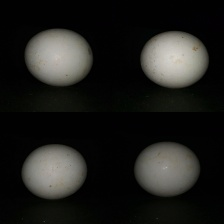

Heatmap Prediction


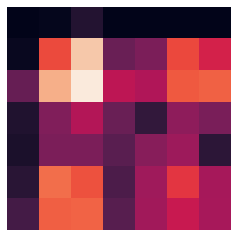

Grad-CAM


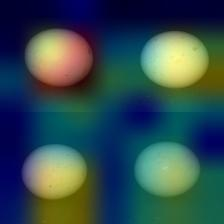

Predict 0, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg.dirty 50.jpg
Original Image


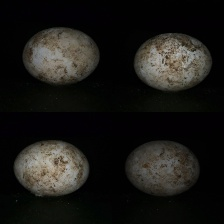

Heatmap Prediction


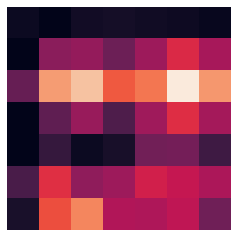

Grad-CAM


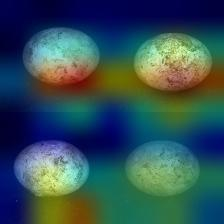

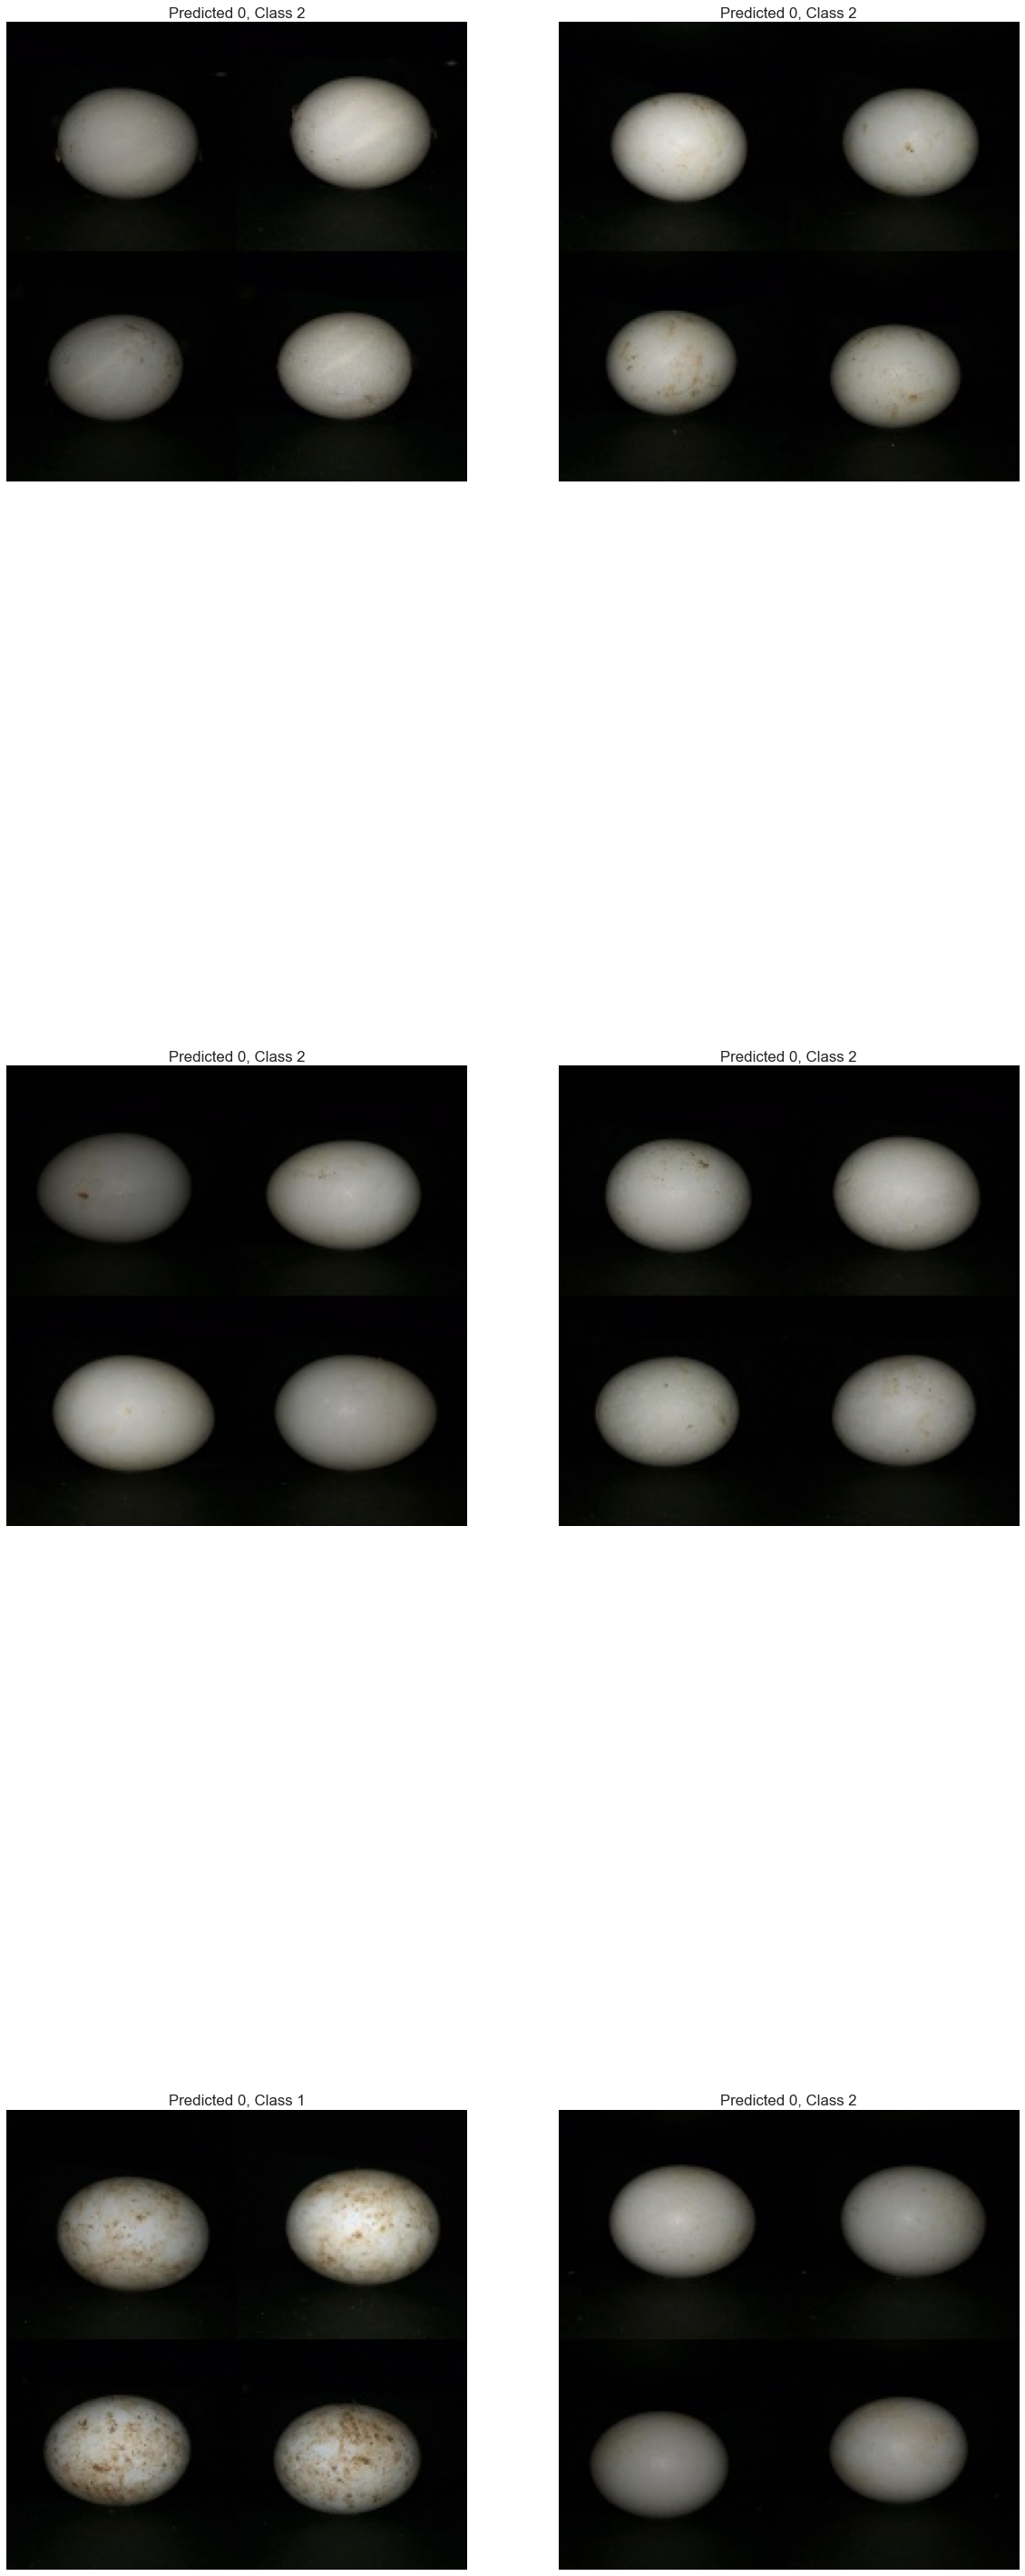

In [52]:
incorrect = np.where(yhat_classes2!=yt)[0]

print ("Found %d incorrect labels" % len(incorrect))

for x in incorrect:
    print("Predict {0}, Class {1}".format(str(yhat_classes2[x]),str(yt.values[x])))
    img_dir = X_test.iloc[x]['filename']
    print(img_dir)
    guraducamu(img_dir)

plt.figure(figsize=(20,60))
for i, incorrect in enumerate(incorrect[:6]):
    plt.subplot(3,2,i+1)
    RGB_img = cv2.cvtColor(testX2[incorrect], cv2.COLOR_BGR2RGB)
    plt.imshow(RGB_img) #, interpolation='none') #, cmap='gray')
    plt.title("Predicted {0}, Class {1}".format(str(yhat_classes2[incorrect]), str(yt.values[incorrect])))
    plt.grid(False)
    plt.axis('off')

plt.show()